In [0]:
from torch import Tensor, matmul, zeros_like
from torch import sum as torch_sum
from torch import argmax as torch_argmax
from torch import abs as torch_abs

from copy import deepcopy
from math import pi, ceil
import matplotlib.pyplot as plt

# from torch import set_grad_enabled
# set_grad_enabled(False)

In [0]:
def generate_disc_set(nb, from_=0, to_=1, one_hot_encoding=False):
	try:
		input = Tensor(nb, 2).uniform_(from_, to_)
		target = input.add(-.5).pow(2).sum(1).sub( 1/ (2*pi)).sign().add(1).div(2).long() ## dataset 1
		# target = input.pow(2).sum(1).sub( 1/ (2*pi)).sign().add(1).div(2).long() ## dataset 2
		if one_hot_encoding:
			new_target = zeros_like(input)
			new_target[:,1][target >= 0.5] = 1
			new_target[:,0][target < 0.5] = 1
			return input, new_target
		return input, target
	except (RuntimeError):
		print(f"error in generate_disc_set() function, from val {from_} should be lower than to {to_}.")
		exit()

In [0]:
def plot_data(train_input, train_target, test_input, test_target,title="Train and Test for each Target"): 
  # for train samples - label 1
  x1=(train_input[train_target[:,0]>=0.5].narrow(1,0,1).view(-1)).numpy();
  y1=(train_input[train_target[:,0]>=0.5].narrow(1,1,1).view(-1)).numpy();
  # for train samples -  0
  x0=(train_input[train_target[:,0]<0.5].narrow(1,0,1).view(-1)).numpy();
  y0=(train_input[train_target[:,0]<0.5].narrow(1,1,1).view(-1)).numpy();
  # for test sample - label 1
  x1_test=(test_input[test_target[:,0]>=0.5].narrow(1,0,1).view(-1)).numpy();
  y1_test=(test_input[test_target[:,0]>=0.5].narrow(1,1,1).view(-1)).numpy();
  # for test sample - 0
  x0_test=(test_input[test_target[:,0]<0.5].narrow(1,0,1).view(-1)).numpy();
  y0_test=(test_input[test_target[:,0]<0.5].narrow(1,1,1).view(-1)).numpy();
  ## plot the data
  plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
  plt.suptitle(f'{title}')
  subplot=plt.subplot(1,2,1)
  axes = plt.gca();
  plt.title("For label 1");
  subplot.plot(x1,y1,'g.',label="train sample");
  subplot.plot(x1_test,y1_test,'b.', label="test sample");
  plt.legend(loc="lower left");
  subplot=plt.subplot(1,2,2)
  axes = plt.gca();
  plt.title("For label 0");
  subplot.plot(x0,y0,'g.', label="train sample");
  subplot.plot(x0_test,y0_test,'b.', label="test sample");
  plt.legend(loc="upper right");

def plot_prediction_data(test_input, test_target, test_prediction, title=""): 
  # # for train samples - label 1
  x1=(test_input[test_prediction[:,0]>=0.5].narrow(1,0,1).view(-1)).numpy();
  y1=(test_input[test_prediction[:,0]>=0.5].narrow(1,1,1).view(-1)).numpy();
  # # for les -  0
  x0=(test_input[test_prediction[:,0]<0.5].narrow(1,0,1).view(-1)).numpy();
  y0=(test_input[test_prediction[:,0]<0.5].narrow(1,1,1).view(-1)).numpy();


  x_error=(test_input[test_prediction[:,0]!= test_target[:,0]].narrow(1,0,1).view(-1)).numpy();
  y_error=(test_input[test_prediction[:,0]!= test_target[:,0]].narrow(1,1,1).view(-1)).numpy();


  ## plot the data
  plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
  plt.title(f'{title}')
  axes = plt.gca();
  # plt.title("For label 1");
  plt.plot(x1,y1,'g.',label="prediction 1");
  plt.plot(x0,y0,'b.',label="prediction 0");
  plt.plot(x_error,y_error,'rx',label="prediction errors");
  plt.legend(loc="upper right");

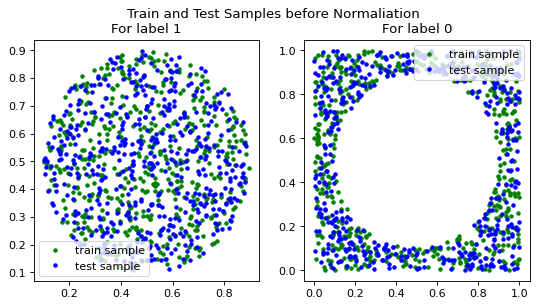

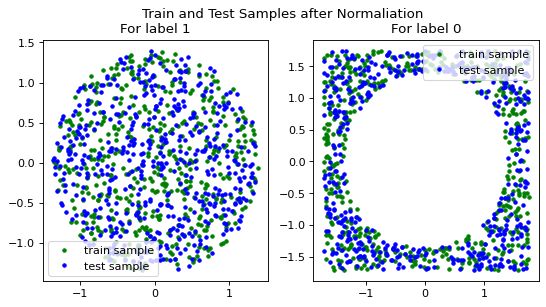

In [4]:
train_size = 1000
mini_batch_size = 500
with_one_hot_encoding = True
train_input, train_target = generate_disc_set(train_size,one_hot_encoding=with_one_hot_encoding)
test_input, test_target = generate_disc_set(train_size, one_hot_encoding=with_one_hot_encoding)
plot_data(train_input, train_target, test_input, test_target, title="Train and Test Samples before Normaliation")

mean, std = train_input.mean(), train_input.std()
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)
plot_data(train_input, train_target, test_input, test_target, title="Train and Test Samples after Normaliation")
mini_batch_size = min(train_size,mini_batch_size)

In [0]:
def NNcompute_nb_errors(model, data_input, data_target, one_hot_encoding=False, mini_batch_size=None): 
    if mini_batch_size is None:
        mini_batch_size = len(data_input)
    nb_data_errors = 0
    if one_hot_encoding:
      data_target = torch_argmax(data_target, dim=1, keepdim= False).data  #torch.argmax as torch_argmax
    for b in range(0, data_input.size(0), mini_batch_size):
        output = model.forward(data_input.narrow(0, b, mini_batch_size))
        if one_hot_encoding:
          output = torch_argmax(output, dim=1, keepdim= False).data   #torch.argmax as torch_argmax
        for k in range(mini_batch_size):
            if data_target[b + k] != output[k]:
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors

## Keras Functions re-implemented

In [0]:
class NNLinear(object):
  def __init__(self,insize,outsize, lr=0.1):
    self.insize = insize
    self.outsize = outsize
    self.weight = Tensor(outsize, insize).uniform_(-1, 1)
    self.bias = Tensor(outsize).uniform_(-1, 1)
    self.input_ = None
    self.lr = lr
    self.output = None
    self.output_grad = None
  def forward (self, input_):
    output = input_.matmul(self.weight.t())
    output += self.bias
    self.input_ = input_
    self.output = output
    return output
  def backward (self, gradwrtoutput):
    output_grad = gradwrtoutput.mm(self.weight)
    self.weight = self.weight- matmul( gradwrtoutput.view(-1,self.outsize,1), self.input_.view(-1,1,self.insize)).sum(0) * self.lr
    self.bias = self.bias - gradwrtoutput.sum(0) * self.lr
    self.output_grad = output_grad
    return output_grad
  def set_learning_rate(self, lr):
    self.lr = lr
  def param (self):
    return [self.output, self.output_grad] 

In [0]:
class NNTanh(object):
  def __init__(self):
    self.input_ = None
  def forward (self, input_):
    output = (input_.mul(2).exp() - 1)/ (input_.mul(2).exp() + 1) 
    self.input_ = input_
    # self.output = output
    return output
  def backward (self, gradwrtoutput):
    return 4 * (self.input_.exp() + self.input_.mul(-1).exp()).pow(-2) * gradwrtoutput
  def param (self):
    return []

In [0]:
class NNRelu(object):
  def __init__(self):
    self.input_ = None
  def forward (self, input_):
    output = input_.clamp(min=0)
    self.input_ = input_
    return output
  def backward (self, gradwrtoutput):
    grad_output = gradwrtoutput.clone()
    grad_output[self.input_ < 0] = 0
    # print (gradwrtoutput)
    return grad_output
  def param (self):
    return []

In [0]:
class NNSequential(object):
  def __init__(self,*args):
    self.NNobject_list = args
    self.lr = 0.1
    self.out = None
    self.target = None
    self.lossval_array = []
    self.epoch_lossval_array = []
    self.batches_per_epoch = 0
    self.last_epoch_loss = 10000
    self.min_loss = 10000
    self.best_obj_array = []
    self.loss_function = self.lossMSE
    self.dloss_function = self.dlossMSE
  def forward (self, x0):
    mid_result = self.NNobject_list[0].forward(x0)
    if len(self.NNobject_list)>1:
      for obj_idx in range(1, len(self.NNobject_list)): # for all NN objects except first one
        mid_result = self.NNobject_list[obj_idx].forward(mid_result)
    out = zeros_like(mid_result) 
    out[mid_result > 0] = 1
    self.out = out
    return out
  def backward (self):
    mid_grad = self.dloss_function(self.out, self.target.view(-1,len(self.out[0])))  ## <----------- check this last param
    if len(self.NNobject_list)>1:
      for obj_idx in range(len(self.NNobject_list)-1,-1,-1): # for all NN objects in reverse order
        mid_grad = self.NNobject_list[obj_idx].backward(mid_grad)
  def loss (self,target):
    self.target = target   
    lossval = self.loss_function(self.out, target)
    self.lossval = lossval
    self.lossval_array.append(lossval)
    return lossval
  def param (self):
    return []
  def lossMSE(self, v, t):
    return torch_sum((v-t).pow(2))
  def dlossMSE(self, v, t):
    return 2*(v-t)
  def lossMAE(self, v, t):
    # print("with MAE")
    return torch_sum(torch_abs(v-t))
  def dlossMAE(self, v, t):
    out = zeros_like(v)
    out[ (v-t) < 0] = -1
    out[ (v-t) > 0] = 1
    return out
  def set_loss_function(self, lossf):
    if (lossf=="MAE"):
      print("using the MAE as loss function.")
      self.loss_function = self.lossMAE
      self.dloss_function = self.dlossMAE
    elif (lossf=="MSE"):
      print("using the MSE as loss function.")
      self.loss_function = self.lossMSE
      self.dloss_function = self.dlossMSE
    else:
      print('given loss function is incorrect. so MSE is used as the loss function')

  def set_learning_rate(self, lr):
    self.lr = lr
    for obj_idx in range(0, len(self.NNobject_list)):
      if isinstance(self.NNobject_list[obj_idx], NNLinear):
        self.NNobject_list[obj_idx].set_learning_rate(lr)
  def train_network(self, train_input, train_target, epoch_count= None, mini_batch_size=None, early_stopping=False, look_back_count_early_stopping=None):
    # testing conditions: 
    if mini_batch_size is None:
      mini_batch_size = len(train_input)
    if epoch_count is None:
      epoch_count = 10
      print (f'Since epoch_count was not defined, value {epoch_count} has been assigned.')
    if (len(train_input) != len(train_target)):
      print(f'Error: input and target lenghts are not equal')
      return 0
    if early_stopping:
      self.batches_per_epoch = ceil(len(train_input)/mini_batch_size)
      if look_back_count_early_stopping is None:
        look_back_count_early_stopping = 10
        print (f'Since look_back_count_early_stopping was not defined with early_stopping set to True, value {look_back_count_early_stopping} has been assigned.')
    # training...
    for k in range(epoch_count): ## for each epoch
      for b in range(0, train_input.size(0), mini_batch_size): ## for each batch
        output = self.forward(train_input.narrow(0, b, mini_batch_size))
        self.loss(train_target.narrow(0, b, mini_batch_size))
        if early_stopping:  ## to stop training incase we get the expected loss
          epoch_loss = sum(self.lossval_array[-self.batches_per_epoch:])
          if epoch_loss > self.last_epoch_loss: ## if new loss is higher than the previous one
            if self.min_loss > self.last_epoch_loss:
              self.min_loss = self.last_epoch_loss
              self.best_obj_array = []
              # save object correspond to the best loss
              for obj_idx in range(0, len(self.NNobject_list)):
                if isinstance(self.NNobject_list[obj_idx], NNLinear):
                  self.best_obj_array.append(deepcopy(self.NNobject_list[obj_idx]))
                else:
                  self.best_obj_array.append(self.NNobject_list[obj_idx])
          self.last_epoch_loss = epoch_loss
          # print(f'{k} - {epoch_loss}') 
        self.backward() 
      self.epoch_lossval_array.append(sum(self.lossval_array[-self.batches_per_epoch:]))
      if early_stopping:  ## to stop training incase we get the expected loss
        if (k>look_back_count_early_stopping and min(self.epoch_lossval_array[-look_back_count_early_stopping:])>= self.min_loss):
          print("early finishing because early stopping")
          self.NNobject_list = self.best_obj_array
          return 1
        elif epoch_loss == 0:
          print('early finishing because loss is zero...')
          return 1


## Results


In [0]:
epoch_count = 600
learnig_rate = 100/(epoch_count * train_size)
in_feature_size = len(train_input[0])
out_feature_size = len(train_target[0])
early_stoping = True
look_back_count_early_stopping = 200

Using model with Relu...
using the MSE as loss function.
early finishing because early stopping
train error percentage: 0.3% (error count: 3)
test error percentage: 1.5% (error count: 15)


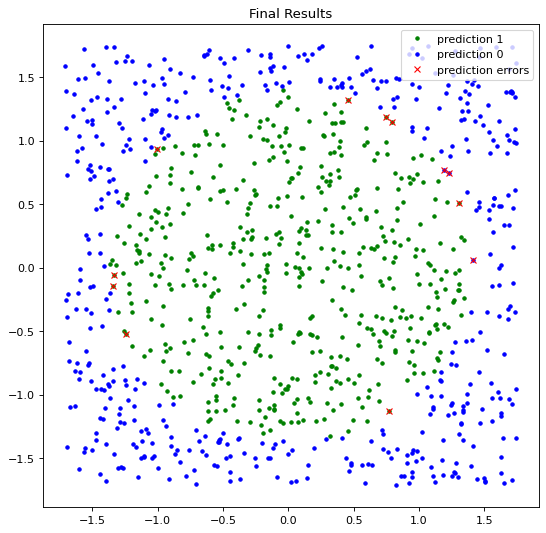

In [16]:
loss_type = 'MSE'
print('Using model with Relu...')
nnmodel = NNSequential(NNLinear(in_feature_size,25),NNRelu(),NNLinear(25,25),NNRelu(),NNLinear(25,25),NNRelu(),NNLinear(25,out_feature_size) )
nnmodel.set_learning_rate(learnig_rate)
nnmodel.set_loss_function(loss_type)

nnmodel.train_network(train_input, train_target, epoch_count= epoch_count, mini_batch_size=mini_batch_size, early_stopping=early_stoping, look_back_count_early_stopping=look_back_count_early_stopping)

train_error_count = NNcompute_nb_errors(nnmodel, train_input, train_target, one_hot_encoding= with_one_hot_encoding, mini_batch_size=mini_batch_size)
test_error_count = NNcompute_nb_errors(nnmodel, test_input, test_target, one_hot_encoding= with_one_hot_encoding, mini_batch_size=mini_batch_size)
print (f'train error percentage: {round(train_error_count/len(train_input)*100, 2)}% (error count: {train_error_count})')
print (f'test error percentage: {round(test_error_count/len(test_input)*100,2)}% (error count: {test_error_count})')
test_prediction = nnmodel.forward(test_input)
plot_prediction_data(test_input, test_prediction, test_target, title="Final Results")

Using model with Relu...
using the MAE as loss function.
early finishing because early stopping
train error percentage: 0.1% (error count: 1)
test error percentage: 1.8% (error count: 18)


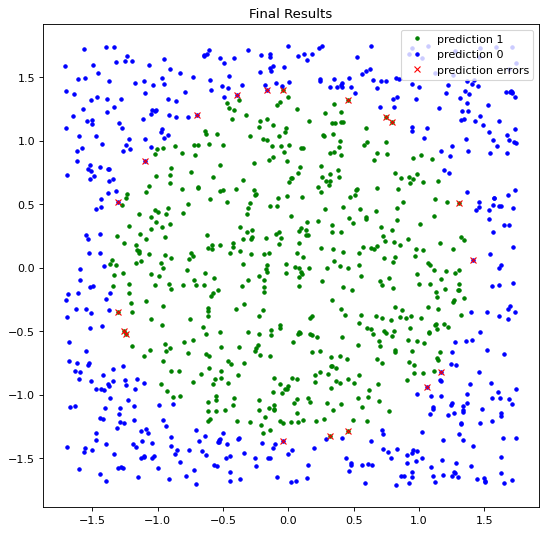

In [17]:
loss_type = 'MAE'
print('Using model with Relu...')

nnmodel = NNSequential(NNLinear(in_feature_size,25),NNRelu(),NNLinear(25,25),NNRelu(),NNLinear(25,25),NNRelu(),NNLinear(25,out_feature_size) )
nnmodel.set_learning_rate(learnig_rate)
nnmodel.set_loss_function(loss_type)

nnmodel.train_network(train_input, train_target, epoch_count= epoch_count, mini_batch_size=mini_batch_size, early_stopping=early_stoping, look_back_count_early_stopping=look_back_count_early_stopping)

train_error_count = NNcompute_nb_errors(nnmodel, train_input, train_target, one_hot_encoding= with_one_hot_encoding, mini_batch_size=mini_batch_size)
test_error_count = NNcompute_nb_errors(nnmodel, test_input, test_target, one_hot_encoding= with_one_hot_encoding, mini_batch_size=mini_batch_size)
print (f'train error percentage: {round(train_error_count/len(train_input)*100, 2)}% (error count: {train_error_count})')
print (f'test error percentage: {round(test_error_count/len(test_input)*100,2)}% (error count: {test_error_count})')
test_prediction = nnmodel.forward(test_input)
plot_prediction_data(test_input, test_prediction, test_target, title="Final Results")

Using model with Tanh...
using the MSE as loss function.
early finishing because early stopping
train error percentage: 0.7% (error count: 7)
test error percentage: 1.8% (error count: 18)


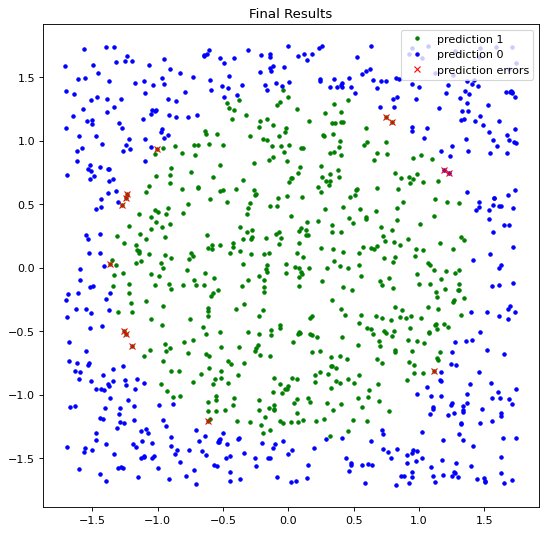

In [18]:

loss_type = 'MSE'
print('Using model with Tanh...')

nnmodel = NNSequential(NNLinear(in_feature_size,25),NNTanh(),NNLinear(25,25),NNTanh(),NNLinear(25,25),NNTanh(),NNLinear(25,out_feature_size) )
nnmodel.set_learning_rate(learnig_rate)
nnmodel.set_loss_function(loss_type)

nnmodel.train_network(train_input, train_target, epoch_count= epoch_count, mini_batch_size=mini_batch_size, early_stopping=early_stoping, look_back_count_early_stopping=look_back_count_early_stopping)

train_error_count = NNcompute_nb_errors(nnmodel, train_input, train_target, one_hot_encoding= with_one_hot_encoding, mini_batch_size=mini_batch_size)
test_error_count = NNcompute_nb_errors(nnmodel, test_input, test_target, one_hot_encoding= with_one_hot_encoding, mini_batch_size=mini_batch_size)
print (f'train error percentage: {round(train_error_count/len(train_input)*100, 2)}% (error count: {train_error_count})')
print (f'test error percentage: {round(test_error_count/len(test_input)*100,2)}% (error count: {test_error_count})')
test_prediction = nnmodel.forward(test_input)
plot_prediction_data(test_input, test_prediction, test_target, title="Final Results")

Using model with Tanh...
using the MAE as loss function.
early finishing because early stopping
train error percentage: 1.3% (error count: 13)
test error percentage: 1.9% (error count: 19)


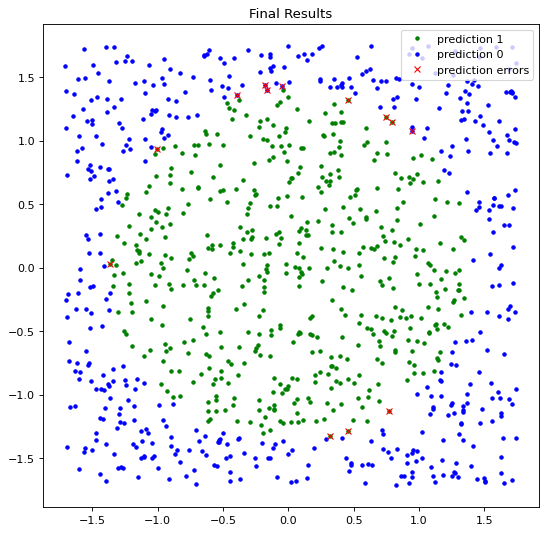

In [19]:
loss_type = 'MAE'
print('Using model with Tanh...')

nnmodel = NNSequential(NNLinear(in_feature_size,25),NNTanh(),NNLinear(25,25),NNTanh(),NNLinear(25,25),NNTanh(),NNLinear(25,out_feature_size) )
nnmodel.set_learning_rate(learnig_rate)
nnmodel.set_loss_function(loss_type)

nnmodel.train_network(train_input, train_target, epoch_count= epoch_count, mini_batch_size=mini_batch_size, early_stopping=early_stoping, look_back_count_early_stopping=look_back_count_early_stopping)

train_error_count = NNcompute_nb_errors(nnmodel, train_input, train_target, one_hot_encoding= with_one_hot_encoding, mini_batch_size=mini_batch_size)
test_error_count = NNcompute_nb_errors(nnmodel, test_input, test_target, one_hot_encoding= with_one_hot_encoding, mini_batch_size=mini_batch_size)
print (f'train error percentage: {round(train_error_count/len(train_input)*100, 2)}% (error count: {train_error_count})')
print (f'test error percentage: {round(test_error_count/len(test_input)*100,2)}% (error count: {test_error_count})')
test_prediction = nnmodel.forward(test_input)
plot_prediction_data(test_input, test_prediction, test_target, title="Final Results")